# Introducing  Deep Learning for Time Series

#### Loading Libraries

In [90]:

# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [2]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
# Tensorflow Version
print(tf.__version__)

2.15.0


In [5]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

#### Loading Data & Performing Data Exploration

In [67]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/metro_interstate_traffic_volume_preprocessed.csv')
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0.0,0.0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0.0,0.0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0.0,0.0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0.0,0.0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0.0,0.0,2443.0


In [68]:
df.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17546,2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0
17547,2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0
17548,2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0
17549,2018-09-30 22:00:00,282.09,0.0,0.0,90.0,1450.0
17550,2018-09-30 23:00:00,282.12,0.0,0.0,90.0,954.0


In [69]:
df.shape

(17551, 6)

##### Plotting 1st Diagnose

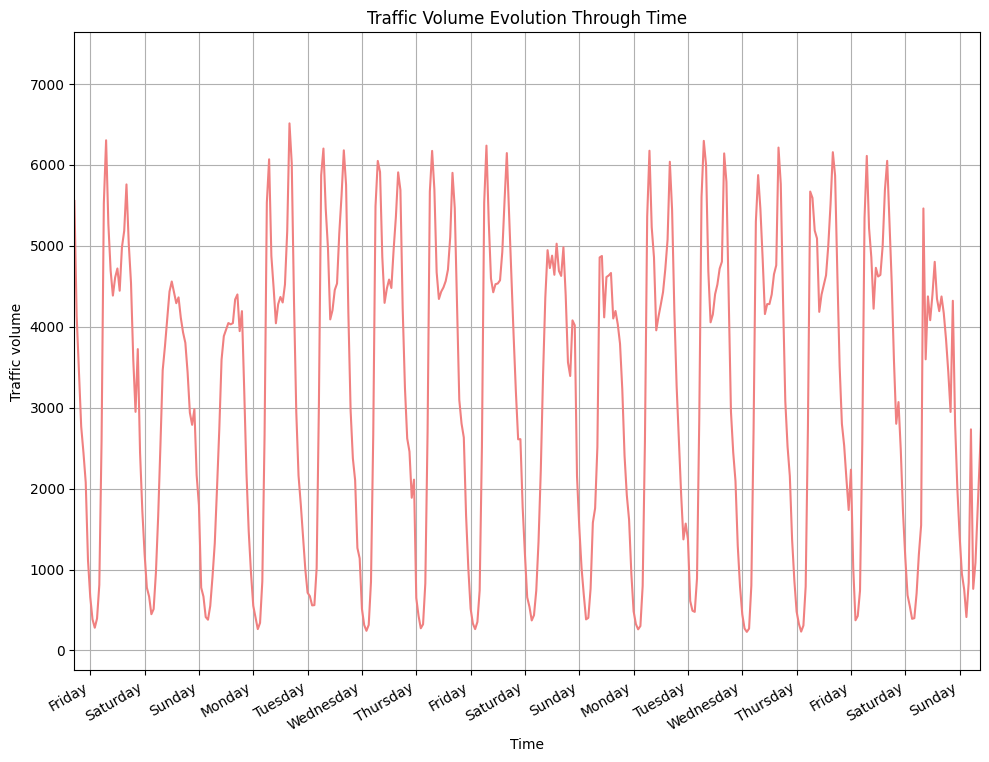

In [70]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'], color='lightcoral')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')
ax.grid(True)

plt.xticks(np.arange(7, 400, 24), 
           ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
            'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
            'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Traffic Volume Evolution Through Time')
plt.show()

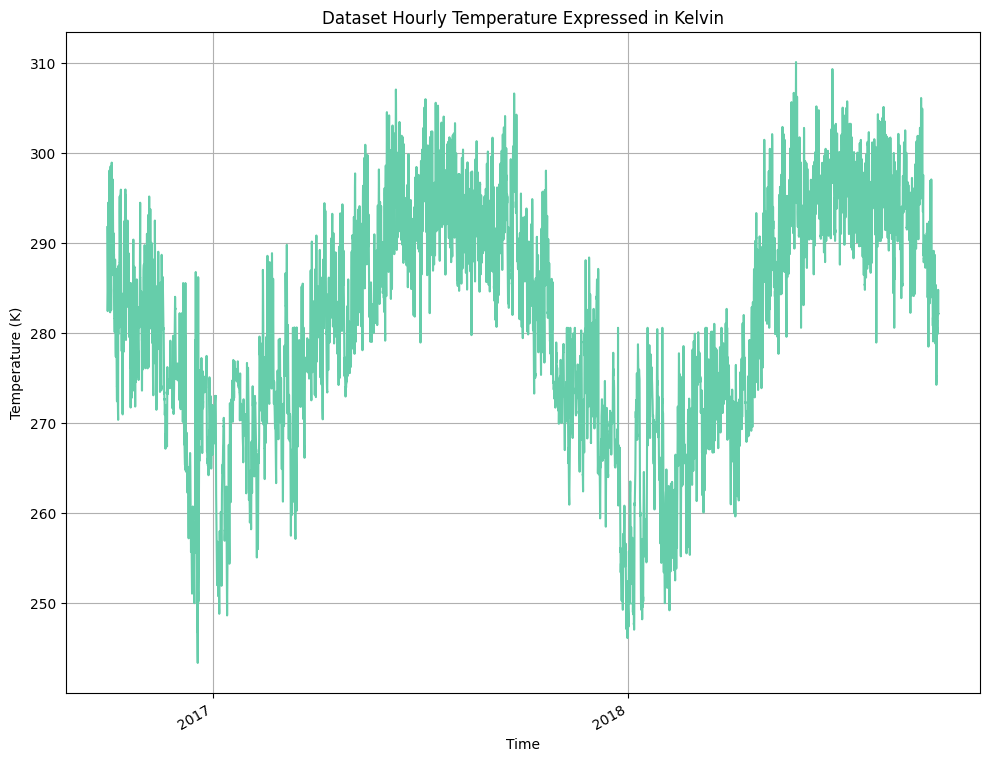

In [71]:
# Overall Hourly Temperature
fig, ax = plt.subplots()

ax.plot(df['temp'], color='mediumaquamarine')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
ax.grid(True)

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Dataset Hourly Temperature Expressed in Kelvin')
plt.show()

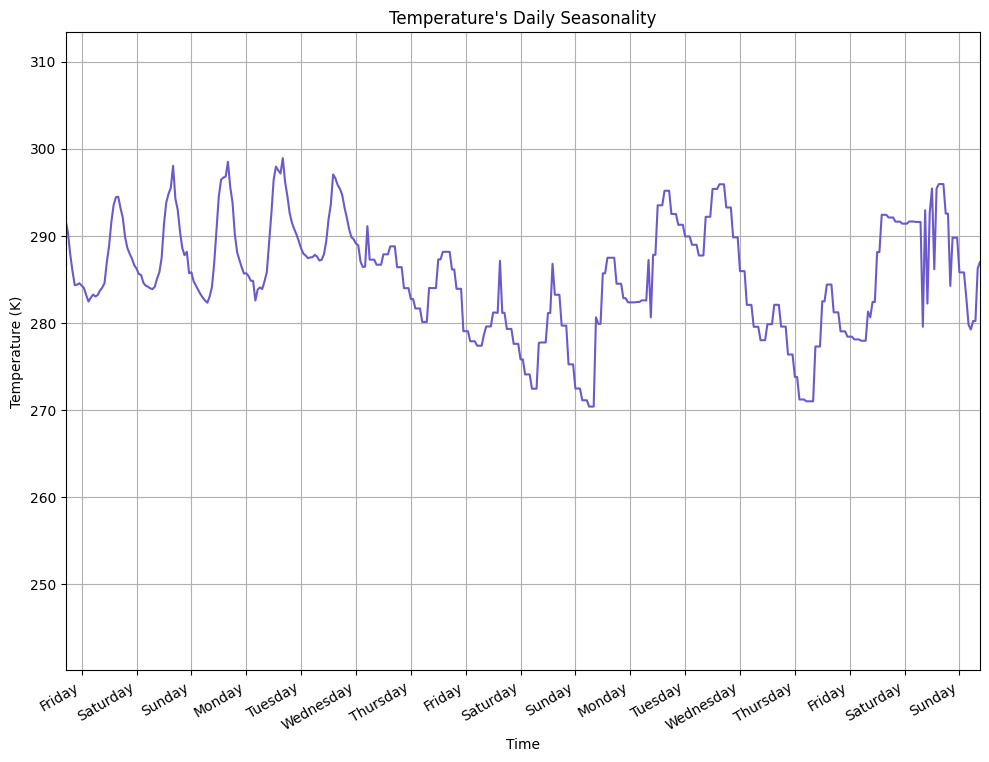

In [72]:
# Daily Seasonality Temperature
fig, ax = plt.subplots()

ax.plot(df['temp'], color= 'slateblue')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
ax.grid(True)

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()
plt.title("Temperature's Daily Seasonality")
plt.show()

#### Feature Engineering 

In [73]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [74]:
# Removing Non-Strong Predictor 
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

In [75]:
df.shape

(17551, 4)

In [76]:
df.head()

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,2443.0


##### Swithching Expressed 'DateTime' Feature into Seconds

In [77]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

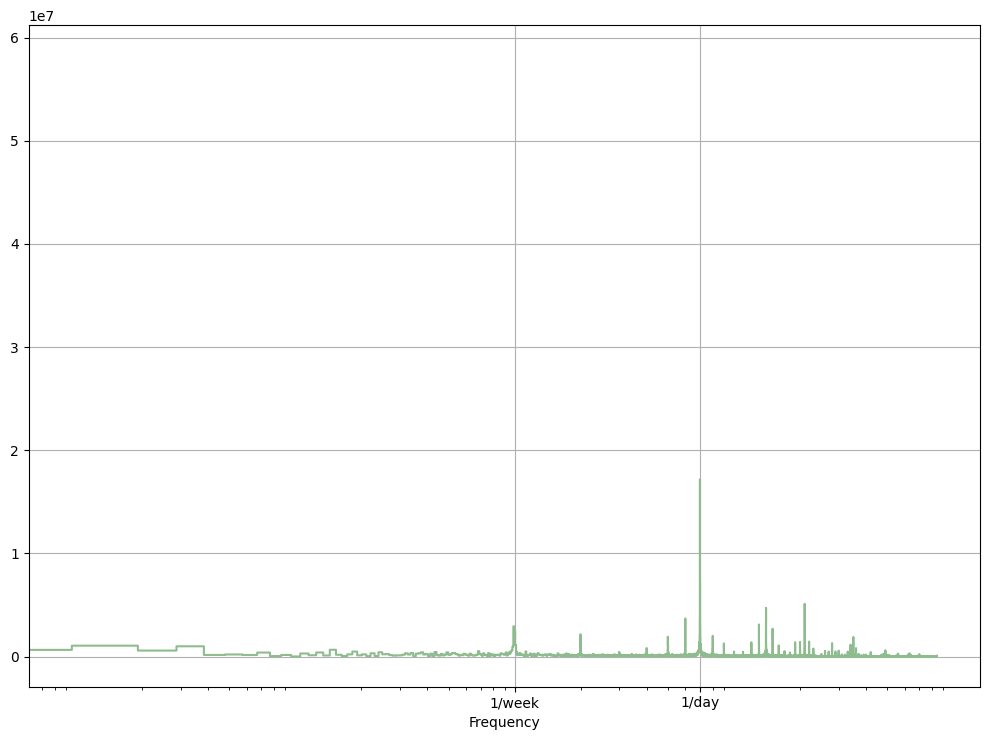

In [78]:
fft = tf.signal.rfft(df['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['traffic_volume'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft), color='darkseagreen')
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Recovering Cyclical Behaviour

In [79]:
# Daily Number of Seconds 
day = 24 * 60 * 60

# Sine Transformation
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
# Cosine Transformation
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [80]:
df.head()

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,291.75,0.0,5551.0,-2.588190e-01,0.965926
1,2016-09-29 18:00:00,290.36,0.0,4132.0,-6.611980e-12,1.000000
2,2016-09-29 19:00:00,287.86,0.0,3435.0,2.588190e-01,0.965926
3,2016-09-29 20:00:00,285.91,0.0,2765.0,5.000000e-01,0.866025
4,2016-09-29 21:00:00,284.31,0.0,2443.0,7.071068e-01,0.707107


In [81]:
# Removing 'date_time' column
df = df.drop(['date_time'], axis=1)

df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0.0,5551.0,-2.588190e-01,0.965926
1,290.36,0.0,4132.0,-6.611980e-12,1.000000
2,287.86,0.0,3435.0,2.588190e-01,0.965926
3,285.91,0.0,2765.0,5.000000e-01,0.866025
4,284.31,0.0,2443.0,7.071068e-01,0.707107


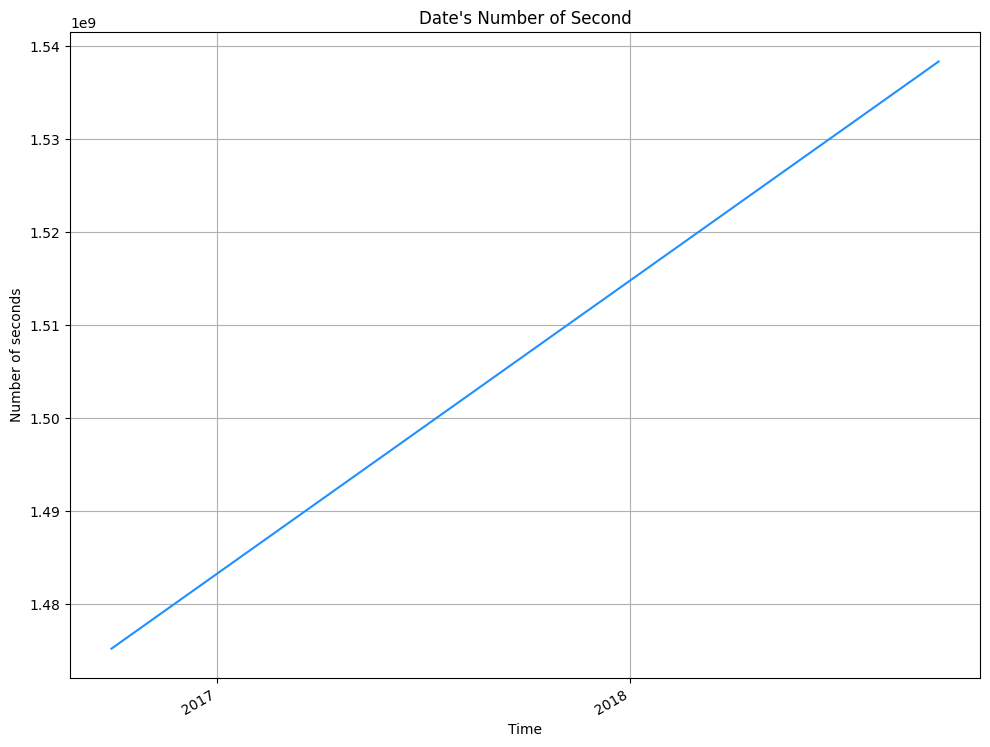

In [84]:
fig, ax = plt.subplots()

ax.plot(timestamp_s, color='dodgerblue')
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')
ax.grid(True)

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()
plt.title("Date's Number of Second")
plt.show()

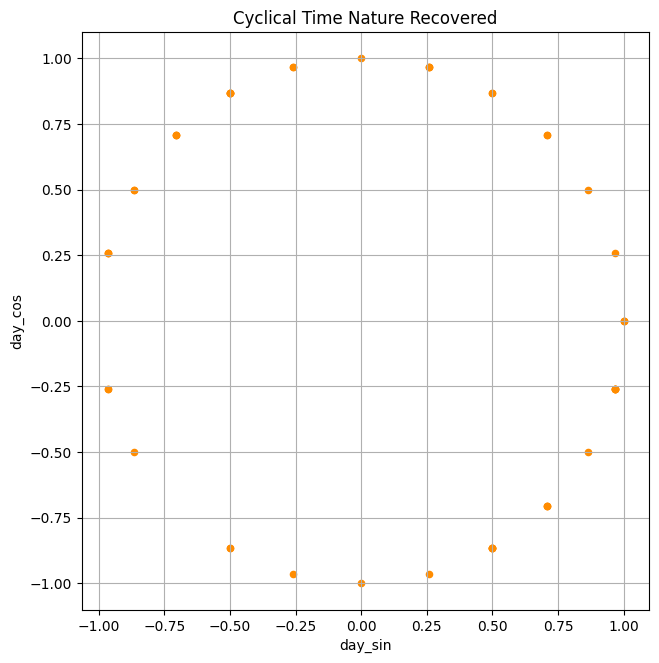

In [85]:
df.sample(50).plot.scatter('day_sin', 'day_cos', color='darkorange').set_aspect('equal');
plt.grid(True)
plt.title('Cyclical Time Nature Recovered')
plt.show()

#### Data Split Procedure: Train - 70% / Validation - 20% / Test Sets - 10%

In [86]:
n = len(df)

In [88]:
# Split 70:20:10 (train:validation:test)

# Train Set
train_df = df[0:int(n*0.7)]
# Validation Set
val_df = df[int(n*0.7):int(n*0.9)]
# Test Set
test_df = df[int(n*0.9):]

In [89]:
train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

#### Data Scaling 

In [91]:
scaler = MinMaxScaler()
scaler.fit(train_df)

# Train Scaling
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])

# Validation Scaling
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])

# Test Scaling
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [92]:
train_df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.0,0.758755,0.370590,0.982963
1,0.738174,0.0,0.560765,0.500000,1.000000
2,0.698884,0.0,0.463513,0.629410,0.982963
3,0.668238,0.0,0.370029,0.750000,0.933013
4,0.643093,0.0,0.325101,0.853553,0.853553


In [93]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12285.0,0.555681,0.196527,0.0,0.424800,0.557913,0.715072,1.0
clouds_all,12285.0,0.431034,0.393716,0.0,0.010000,0.400000,0.900000,1.0
traffic_volume,12285.0,0.445735,0.273635,0.0,0.165899,0.473141,0.671271,1.0
day_sin,12285.0,0.500007,0.353561,0.0,0.146447,0.500000,0.853553,1.0
day_cos,12285.0,0.499948,0.353575,0.0,0.146447,0.500000,0.853553,1.0


#### Saving Data

In [94]:
# Saving Datasets

# Train Set
train_df.to_csv('/Users/isisromero/desktop/time_series/preprocessed/train.csv')
# Validation Set
val_df.to_csv('/Users/isisromero/desktop/time_series/preprocessed/val.csv')
# Test Set
test_df.to_csv('/Users/isisromero/desktop/time_series/preprocessed/test.csv')